## Week 6 Lab (Decision Trees and Random Forest)
COSC 3337 Dr. Rizk 

This lab will walk you through how you can use decision tree and random forest in sklearn on your own datasets. We will also be comparing the two methods.

## Intuition

### The Decision Tree Algorithm
This is a supervised learning algorithm, but unlike other supervised learning algorithms, the decision tree algorithm can be used for solving both regression and classification problems.

The goal of a Decision Tree is to create a model that can predict the class or value of the target variable by learning simple decision rules inferred from the training data.



Decision trees classify the examples by sorting them down the tree from the root to some leaf/terminal node, with the leaf/terminal node providing the classification of the example. Each node in the tree acts as a test case for some attribute, and each edge descending from the node corresponds to the possible answers to the test case. This process is recursive in nature and is repeated for every subtree rooted at the new node.

The primary challenge in the decision tree implementation is to identify which attributes do we need to consider as the root node at each level. For solving this attribute selection problem, researchers have devised some of the following attribute selection measures:

* Entropy,
* Information gain,
* Gini index,
* Gain Ratio,
* Reduction in Variance
* Chi-Square

These criterias will calculate values for every attribute. The values are sorted, and attributes are placed in the tree by following the order i.e, the attribute with the highest value(in case of information gain) is placed at the root.

Note: The most popular attribute selection methods that we'll use in this course are information gain and gini index.

### Potential Problems
Overfitting is a practical problem while building a Decision-Tree model. The problem of overfitting is considered when the algorithm continues to go deeper and deeper to reduce the training-set error but results with an increased test-set error. So, accuracy of prediction for our model goes down. It generally happens when we build many branches due to outliers and irregularities in data.

To avoid overfitting, we can use the following:

* Pre-Pruning: Stop the tree construction a bit early. We prefer not to split a node if its goodness measure is below a threshold value, but it is difficult to choose an appropriate stopping point.
<br>
* Post-Pruning: First generate the decision tree and then remove non-significant branches. Post-pruning a decision tree implies that we begin by generating the (complete) tree and then adjust it with the aim of improving the accuracy on unseen instances.

### About The Data
We'll be using the Car Evaluation Data Set from the UCI Machine Learning Repository for this lab, but feel free to follow along with your own dataset. The dataset contains the following attributes:

buying (v-high, high, med, low)
maint (v-high, high, med, low)
doors (2, 3, 4, 5-more)
persons (2, 4, more)
lug_boot (small, med, big)
safety (low, med, high)
class (unacc, acc, good, vgood)

### Quick Exploratory Data Analysis
Let's begin by importing some necessary libraries that we'll be using to explore the data.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 5
sns.set_style('darkgrid')

Our first step is to lead the data into a pandas DataFrame. For some reason, this dataset did not come with a header/column names, we will specify that when loading the data an manually add the column names oursalves.

In [3]:
car_data = pd.read_csv('car_evaluation.csv', header=None)
car_data.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
car_data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


After checking **.info()** we can see that there are no missing values. Our dataset contains 1728 entries, and each of our columns contains 1728 non-null values.

In [4]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


If we create countplots of each attribure we can see that there seems to be an equal balance of each unique type in each uniqye type in each column.

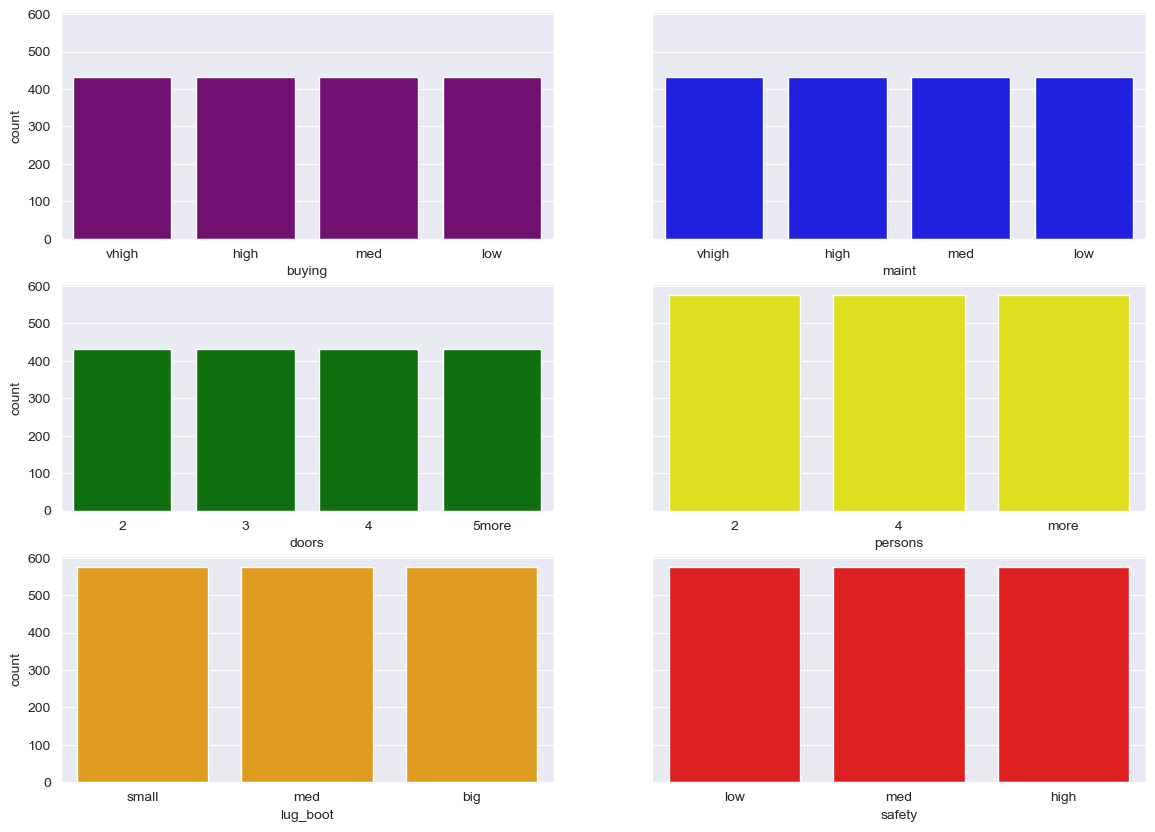

In [5]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, sharey = True, figsize = (14,10))

sns.countplot(x = car_data['buying'], ax = axes[0][0], color = 'purple')
sns.countplot(x = car_data['maint'], ax = axes[0][1], color = 'blue')
sns.countplot(x = car_data['doors'], ax = axes[1][0], color = 'green')
sns.countplot(x = car_data['persons'], ax = axes[1][1], color = 'yellow')
sns.countplot(x = car_data['lug_boot'], ax = axes[2][0], color = 'orange')
sns.countplot(x = car_data['safety'], ax = axes[2][1], color = 'red')

plt.show()

Let's also take a look at our target/class variable

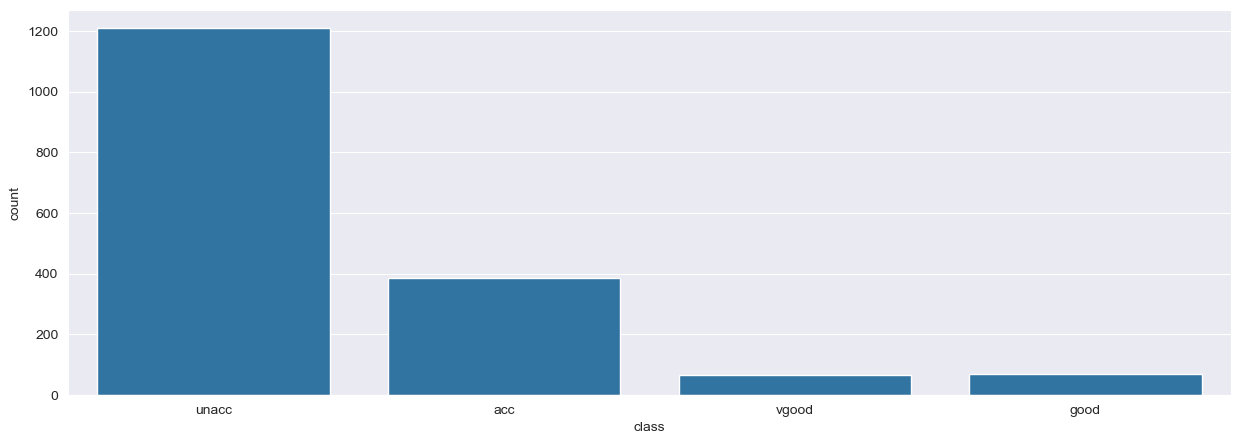

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

In [6]:
sns.countplot(x = car_data['class'])
plt.show()
car_data['class'].value_counts()

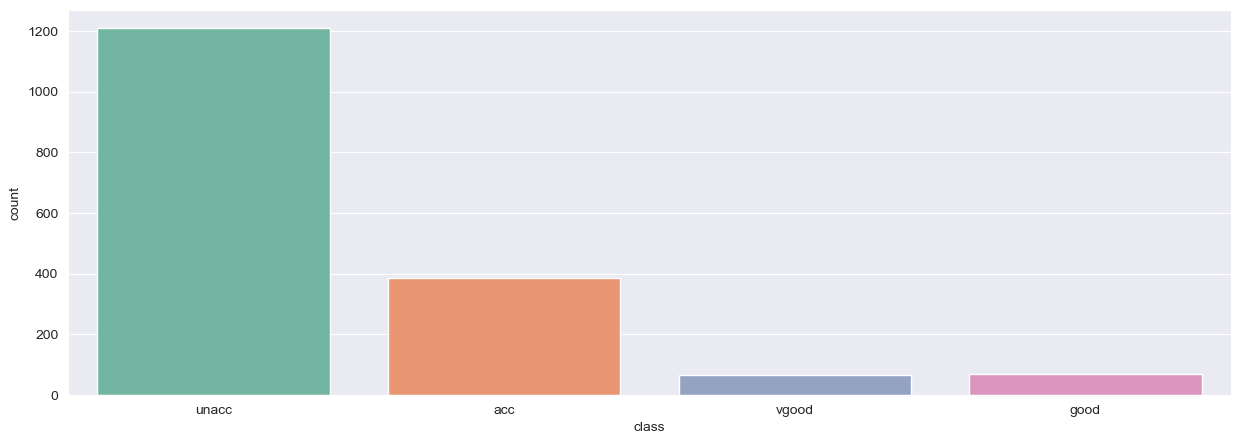

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

In [7]:
sns.countplot(x = car_data['class'], hue = car_data['class'], palette = 'Set2', legend = False)
plt.show()
car_data['class'].value_counts()

Majority of our dataset consists of the unacc and acc, with very few vgood and good records. 

### Data Preprocessing
Let's now prepare our data for training. Notice that all of our variables are ordinal categorical variables. When dealing with ordinal categorical variables, you want to make sure to preserve the order when encoding them, so we can use sklearn's ordinal encoder, or manually map each unique value in each column to some number [0, n_classes-1].

**Note: We can't use one hot encoding / get_dummies here because that won't preserve the order.**

In [8]:
car_data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


One way to do our encoding is by first creating mappings that preserve the order in each column. For example, low category maps to 0, and vhigh category maps with 3. 

In [9]:
buying_mappings = {'low':0, 'med':1, 'high':2, 'vhigh':3}
maint_mappings = {'low':0, 'med':1, 'high':2, 'vhigh':3}
door_mappings = {'2':2, '3':3, '4':4, '5more':5}
persons_mappings = {'2':2, '4':4, 'more':5}
lug_boot_mappings = {'small':0, 'med':1, 'big':2}
safety_mappings = {'low':0, 'med':1, 'high':2}
class_mappings = {'unacc':0, 'acc':1, 'good':2, 'vgood':3}

We can then pass use pandas **.map(dictionary)** to apply our mapping to the necessary columns.

In [10]:
car_data['buying'] = car_data['buying'].map(buying_mappings)
car_data['maint'] = car_data['maint'].map(maint_mappings)
car_data['doors'] = car_data['doors'].map(door_mappings)
car_data['persons'] = car_data['persons'].map(persons_mappings)
car_data['lug_boot'] = car_data['lug_boot'].map(lug_boot_mappings)
car_data['safety'] = car_data['safety'].map(safety_mappings)
car_data['class'] = car_data['class'].map(class_mappings)

Displaying our DataFrame again we can see that it's now ready for training

In [11]:
car_data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,2,2,0,0,0
1,3,3,2,2,0,1,0
2,3,3,2,2,0,2,0
3,3,3,2,2,1,0,0
4,3,3,2,2,1,1,0


### Creating Our Tree Models
We're now ready to begin creating and training our model. We first need to split our data into training and testing sets. This can be done using sklearn's **train_test_split(X, y, test_size)** function. This function takes in your features (X), the target variable (y), and the test_size you'd like (Generally a test size of around 0.3 is good enough). It will then return a tuple of X_train, X_test, y_train, y_test sets for us. We will train our model on the training set and then use the test set to evaluate the model.

In [12]:
from sklearn.model_selection import train_test_split

X = car_data[['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']]
y = car_data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

We'll now import sklearn's DecisionTreeClassifier model and begin training it using the **fit(train_data, train_data_labels) method. In a nutshell, fitting is equal to training. Then, after it is trained, the model can be used to make predictions, usually with a **predict(test_data)** method call.

In [13]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the DecisionTreeClassifier model with criterion gini index
clf_gini = DecisionTreeClassifier(criterion = 'gini', max_depth = 3, random_state = 0)

# fit the model
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

### Model Evaluation
Now that we've finished training, we can make predictions off of the test data and evaluate our model's performance using the corresponding test data labels (y_test).

In [16]:
# predict the test set results with criterion gini
y_pred_gini = clf_gini.predict(X_test)

we'll import sklearn's accuracy_score to evaluate our model. This will take the true values and predictors as input. 

In [19]:
from sklearn.metrics import accuracy_score

print('Training set score: {:.4f}'.format(clf_gini.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf_gini.score(X_test, y_test)))

Training set score: 0.7758
Test set score: 0.7823


Here, the training-set accuracy score is 0.7965 while the test-set accuracy is 0.7803. These two values are quite comparable, so there is no sign of overfitting.

### Visualize decision-trees
Note: Try running the 3 lines of code that are commented out. If the arrows don't appear then you'll have to run the uncommented code to manually fix the arrows. This is a jupyter notebook issue some people face when using sklearn's tree visualizer.

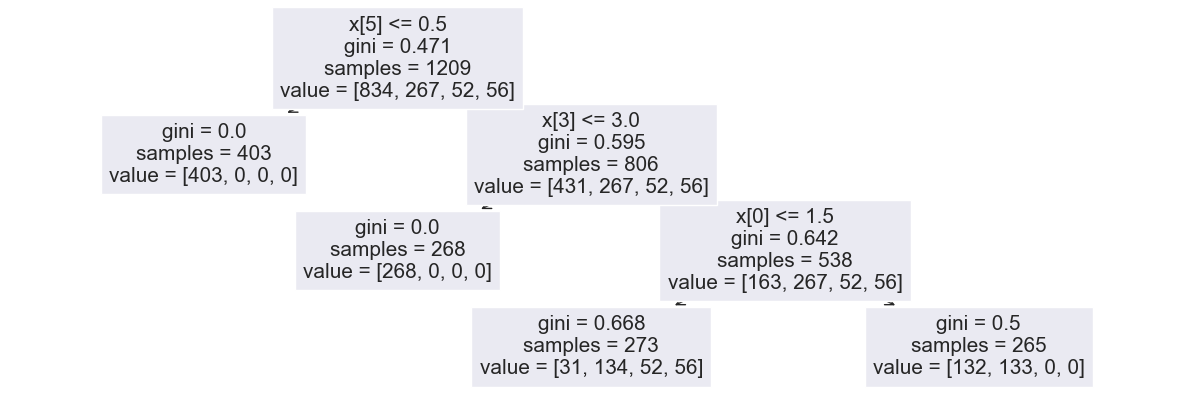

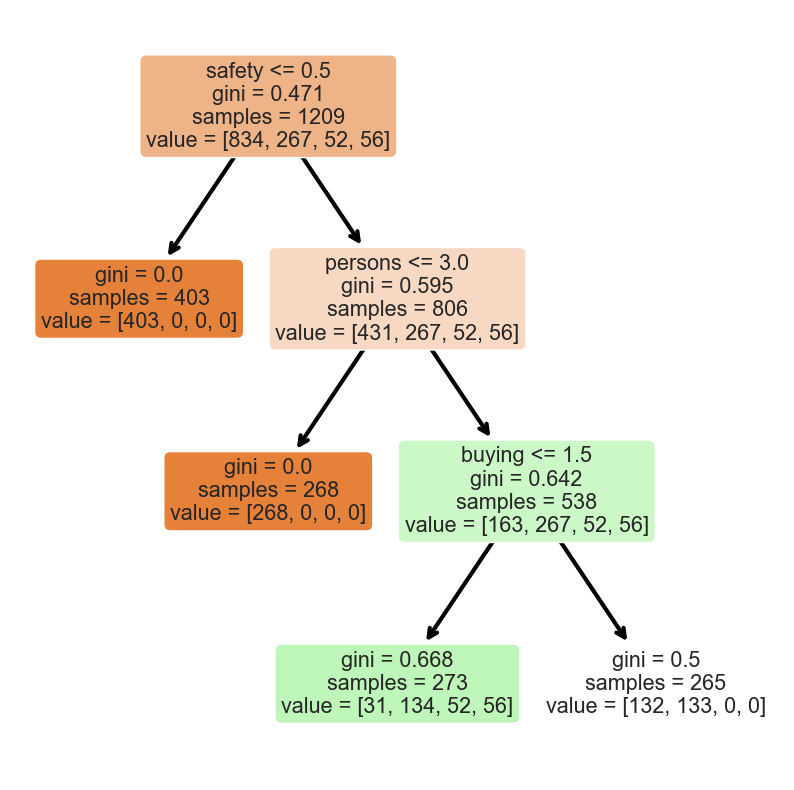

In [22]:
from sklearn import tree
tree.plot_tree(clf_gini)
# plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
out = tree.plot_tree(clf_gini, filled = True, rounded = True,
                     feature_names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

for o in out: 
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)

Awesome! As a bonus exercise, try creating a Decision Tree Classifier with criterion entropy instead.

### Random Forests
Now let's compare the decision tree model to a random forest. This is fairly quick to do using sklearn. 🙂

In [23]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [25]:
rfc_pred = rfc.predict(X_test)
print('Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, rfc_pred)))

Model accuracy score: 0.9827
